In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from scipy import stats
import matplotlib.pyplot as plt

def generate_data(n_train=100, n_test=100, d=5, seed=0):
    np.random.seed(seed)
    X_train = np.random.uniform(-10, 10, size=(n_train, d))
    X_test  = np.random.uniform(-10, 10, size=(n_test,  d))
    w_true  = np.random.randn(d)  # w ~ N(0, I)
    y_train = X_train @ w_true + np.random.randn(n_train)  # noise ~ N(0,1)
    y_test  = X_test @ w_true + np.random.randn(n_test)
    return X_train, y_train, X_test, y_test, w_true

# ----------------------------
# 2. Bayesian Ridge Regression
# ----------------------------
def bayesian_ridge_intervals(X_train, y_train, X_test, y_test, a=1.0, alpha=0.1):
    """
    Implements Bayesian Ridge as described in Sections 3–4 of the paper.
    Posterior: w ~ N(mu, Sigma), where Sigma = (X'X + a I)^{-1}
    Predictive: y* ~ N(x*' mu, 1 + x*' Sigma x*)
    """
    n, d = X_train.shape
    # Compute posterior covariance Sigma = (X'X + a I)^{-1}
    XtX = X_train.T @ X_train
    Sigma = np.linalg.inv(XtX + a * np.eye(d))
    mu = Sigma @ X_train.T @ y_train

    # Predictive mean and variance for each test point
    y_pred = X_test @ mu
    var_pred = np.array([1.0 + x @ Sigma @ x for x in X_test])  # scalar variance
    std_pred = np.sqrt(var_pred)

    # Two-sided Gaussian interval
    z = stats.norm.ppf(1 - alpha / 2)
    lower = y_pred - z * std_pred
    upper = y_pred + z * std_pred

    # Coverage
    covered = (y_test >= lower) & (y_test <= upper)
    coverage = covered.mean()
    mean_width = (upper - lower).mean()
    return coverage, mean_width

# ----------------------------
# 3. Split Conformal Prediction（Corrected Version）
# ----------------------------
def split_conformal_intervals_corrected(X_train, y_train, X_test, y_test, a=1.0, alpha=0.1, seed=0):
    """
    Corrected version: Uses fixed test set to evaluate coverage.
    Splits training data into proper train and calibration sets.
    """
    np.random.seed(seed)
    n_train = len(y_train)
    # Randomly split: 50% proper training, 50% calibration
    idx = np.random.permutation(n_train)
    n_cal = n_train // 5
    cal_idx = idx[:n_cal]
    train_idx = idx[n_cal:]

    X_proper, y_proper = X_train[train_idx], y_train[train_idx]
    X_cal, y_cal = X_train[cal_idx], y_train[cal_idx]

    # Train Ridge on proper training set
    model = Ridge(alpha=a, fit_intercept=False)
    model.fit(X_proper, y_proper)

    # Nonconformity scores on calibration set
    y_pred_cal = model.predict(X_cal)
    scores = np.abs(y_cal - y_pred_cal)

    # Quantile with finite-sample correction (ensures validity)
    q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
    q_level = min(q_level, 1.0)
    q_hat = np.quantile(scores, q_level, method='higher')

    # Predict intervals for the FIXED test set
    y_pred_test = model.predict(X_test)
    lower = y_pred_test - q_hat
    upper = y_pred_test + q_hat

    # Coverage on the fixed test set
    covered = (y_test >= lower) & (y_test <= upper)
    coverage = covered.mean()
    mean_width = (upper - lower).mean()
    return coverage, mean_width

# ----------------------------
# 4. 主实验循环（修正版）
# ----------------------------
alphas = np.linspace(0.01, 0.99, 20)  # significance levels
a_vals = [1, 1000, 10000]
n_rep = 10  # repetitions as in paper

# 生成固定的训练集和测试集
np.random.seed(42)  # 固定种子以确保可复现性
X_train, y_train, X_test, y_test, w_true = generate_data(n_train=100, n_test=100, d=5, seed=42)

# 容器
cov_bayes = {a: [] for a in a_vals}
width_bayes = {a: [] for a in a_vals}
cov_split = {a: [] for a in a_vals}
width_split = {a: [] for a in a_vals}

for a in a_vals:
    print(f"Running a = {a}...")
    for alpha in alphas:
        covs_b, widths_b = [], []
        covs_s, widths_s = [], []
        for rep in range(n_rep):
            # Bayesian (使用完整的训练集)
            cov_b, w_b = bayesian_ridge_intervals(X_train, y_train, X_test, y_test, a=a, alpha=alpha)
            covs_b.append(cov_b); widths_b.append(w_b)
            
            # Split CP: 使用固定的训练集和测试集，只改变内部的分割种子
            cov_s, w_s = split_conformal_intervals_corrected(X_train, y_train, X_test, y_test, a=a, alpha=alpha, seed=rep)
            covs_s.append(cov_s); widths_s.append(w_s)
            
        cov_bayes[a].append(np.mean(covs_b))
        width_bayes[a].append(np.mean(widths_b))
        cov_split[a].append(np.mean(covs_s))
        width_split[a].append(np.mean(widths_s))


Running a = 1...
Running a = 1000...
Running a = 10000...


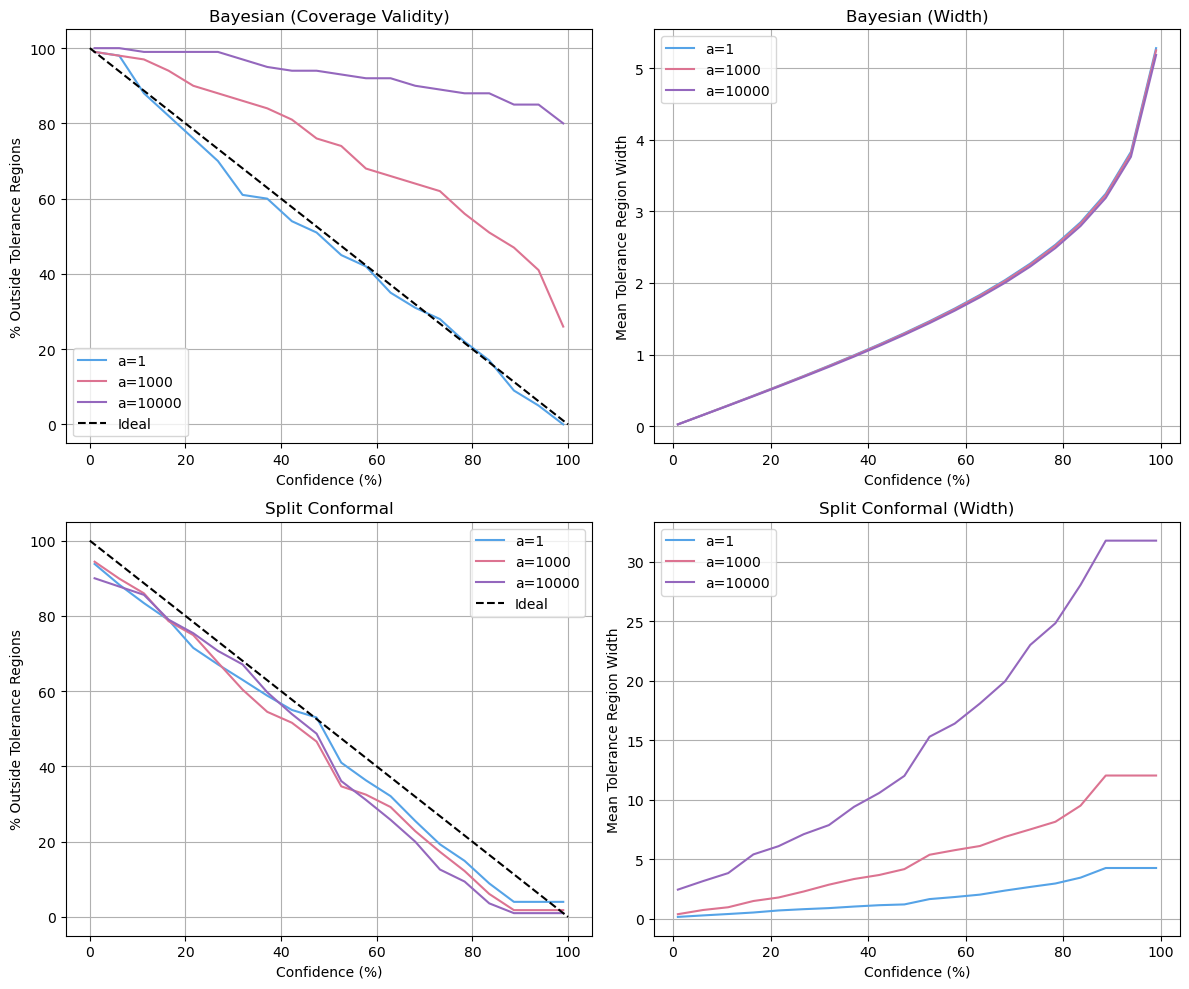

In [5]:
conf_levels = 1 - alphas  # e.g., 0.95 for alpha=0.05

colors = {
    "b":   "#55A3E7",   # light blue
    "pin": "#DC7391",   # rose pink
    "pur": "#9467BD"    # purple
}
palette = [colors["b"], colors["pin"], colors["pur"]]   # 循环用

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# =========================
# Top-left: Bayesian (Coverage)
# =========================
ax = axes[0, 0]
for i, a in enumerate(a_vals):
    ax.plot(
        conf_levels * 100,
        (1 - np.array(cov_bayes[a])) * 100,
        color=palette[i % len(palette)],
        label=f'a={a}'
    )
ax.plot([0, 100], [100, 0], 'k--', label='Ideal')
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('% Outside Tolerance Regions')
ax.set_title('Bayesian (Coverage Validity)')
ax.legend()
ax.grid(True)

# =========================
# Top-right: Bayesian (Width)
# =========================
ax = axes[0, 1]
for i, a in enumerate(a_vals):
    ax.plot(
        conf_levels * 100,
        width_bayes[a],
        color=palette[i % len(palette)],
        label=f'a={a}'
    )
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('Mean Tolerance Region Width')
ax.set_title('Bayesian (Width)')
ax.legend()
ax.grid(True)

# =========================
# Bottom-left: Split CP (Coverage)
# =========================
ax = axes[1, 0]
for i, a in enumerate(a_vals):
    ax.plot(
        conf_levels * 100,
        (1 - np.array(cov_split[a])) * 100,
        color=palette[i % len(palette)],
        label=f'a={a}'
    )
ax.plot([0, 100], [100, 0], 'k--', label='Ideal')
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('% Outside Tolerance Regions')
ax.set_title('Split Conformal')
ax.legend()
ax.grid(True)

# =========================
# Bottom-right: Split CP (Width)
# =========================
ax = axes[1, 1]
for i, a in enumerate(a_vals):
    ax.plot(
        conf_levels * 100,
        width_split[a],
        color=palette[i % len(palette)],
        label=f'a={a}'
    )
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('Mean Tolerance Region Width')
ax.set_title('Split Conformal (Width)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig("../../report/figure/FullBayes_vs_SplitCP.png", dpi=150)
plt.show()
